In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datarobot as dr
from IPython.display import display, Image

pd.options.display.max_rows=100
pd.options.display.max_columns = 100

# DataRobot's Builds on BuzzFeed - Can we better predict surveillance planes over America? 

[Source Article: BuzzFeed News Trained A Computer To Search For Hidden Spy Planes. This Is What We Found](https://www.buzzfeed.com/peteraldhous/hidden-spy-planes?utm_term=.pbMQJ3WKp#.lgdep1d6m)

## Background 
BuzzFeed released a dataset and jupyter notebook recently that analyzed public flight data to identify potential spy planes.  This built on previous BuzzFeed stories on the same topic, which identified and verified spy planes. <br><br> Features from the 97 previously verified surveillance-planes were used as positive training examples in train.csv, as well as 500 randomly selected planes from a sample of 20,000.

BuzzFeed conducted some very clever feature engineering (described below), and used random forests to train on the 597 plane training set using a train/validation split (due to time constraints no cross-validation was done), and then ran predictions on the remaining 19,799 aircraft in their sample. 

BuzzFeed identified 69 likely surveillance planes from their RandomForest prediction, and 19,091 normal aircraft flights.  

[Github](https://buzzfeednews.github.io/2017-08-spy-plane-finder)<br>
[Original Article](https://www.buzzfeed.com/peteraldhous/spies-in-the-skies?utm_term=.phVp8l3DE#.ri7okwGBp)


# Objective
BuzzFeed's data gathering and feature engineering were extremeley clever, and highlight a critical aspect of data science: developing new features from your dataset that enhance predictions. Feature engineering is both art and science, and the team at BuzzFeed did an incredible job deconstructing available flight data to create meaningful featres. In their article, they indicate a few areas of further study that they would like to do but were not able to.  In particular, 

 * Use cross-validation on the training data set to get more generalizable predictions.  BuzzFeed fit their model on the entire training data set to set model parameters, and then ran predictions based on that fit.  While the bagging internal to Random Forests is a robust procedure against overfitting, we will use cross-validation.
 * Evaluate multiple models.  Random Forests is powerful tree-based algorithm that performs well in many settins, but DataRobot will evaluate dozens of models to see which performs best.
 
**This is exactly where leveraging the power of automated machine learning with DataRobot becomes incredibly useful: Allowing Data Scientists to focus on feature engineering, interpretation and evaluation, and letting DataRobot's powerful automation evaluate dozens of models and preprocessing steps, all designed by some of the top Data Scientists in the world**
 
In this notebook we will address the two items BuzzFeed wasn't able to get to, and in the process answer the following questions: 

* *Can we build a more robust model using DataRobot that better predicts surveillance planes?*
* *Can we identify new planes that may have been missed?* 
* *Can we identify new important features in the model, and do our important features line-up with BuzzFeed's important features?*

# First, a review of the data

(per [BuzzFeed's Github)]([Github](https://buzzfeednews.github.io/2017-08-spy-plane-finder)
..We took a random sample of 500 aircraft and calculated the following for each one:

* **duration** of each flight segment recorded by Flightradar24, in minutes.
* **boxes**- Area of a rectangular bounding box drawn around each flight segment, in square kilometers.
* Finally, we calculated the following variables for each of the aircraft in the larger filtered dataset:


* **duration1,duration2,duration3,duration4,duration5** Proportion of flight segment durations for each plane falling into each of five quantiles calculated from duration for the sample of 500 planes. The proportions for each aircraft must add up to 1; if the durations of flight segments for a plane closely matched those for a typical plane from the sample, these numbers would all approximate to 0.2; a plane that mostly flew very long flights would have large decimal fraction for duration5.
* **boxes1,boxes2,boxes3,boxes4,boxes5** Proportion of bounding box areas for each plane falling into each of five quantiles calculated from boxes for the sample of 500 planes.
* **speed1,speed2,speed3,speed4,speed5** Proportion of speed values recorded for the aircraft falling into each of five quantiles recorded for speed for the sample of 500 planes.
* **altitude1,altitude2,altitude3,altitude4,altitude5** Proportion of altitude values recorded for the aircraft falling into each of five quantiles recorded for altitude for the sample of 500 planes.
* **steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8** Proportion of steer values for each aircraft falling into bins set manually, after observing the distribution for the sample of 500 planes, using the breaks: -180, -25, -10, -1, 0, 1, 22, 45, 180.
* **flights** Total number of flight segments for each plane.
* **squawk_1** Squawk code used most commonly by the aircraft.
* **observations** Total number of transponder detections for each plane.
* **type** Aircraft manufacter and model, if identified, else unknown.
The resulting data for 19,799 aircraft are in the file **planes_features.csv**.

# Build Training and Prediction Datasets
(per [BuzzFeed's Github)]([Github](https://buzzfeednews.github.io/2017-08-spy-plane-finder)...As training data, drawn from **planes_features.csv**, we used 97 fixed-wing FBI and DHS planes from our previous story, given a class of  surveil, and a random sample of 500 other planes, given a class of other.

Data identifying these planes is in the file **train.csv**.

In [2]:
#load training data and merge with planes_features
def get_train_data(file1, file2):
    train=pd.read_csv(file1)
    print("Training Columns are", train.columns)
    
    all_planes = pd.read_csv(file2)
    
    merged =train.merge(all_planes, on = 'adshex')
    print("Training data shape is ", train.shape)
    print("FAA plane features shape is ", all_planes.shape) #currently contains train and prediction data
    print('Merged shape is ', merged.shape)
    print(merged.head())
    
    return merged, all_planes

train_data, all_planes = get_train_data('train.csv', 'planes_features.csv')

Training Columns are Index(['adshex', 'class'], dtype='object')
Training data shape is  (597, 2)
FAA plane features shape is  (19799, 33)
Merged shape is  (597, 34)
   adshex    class  duration1  duration2  duration3  duration4  duration5  \
0  A00C4B  surveil   0.450000   0.125000   0.025000   0.025000   0.375000   
1  A0AB21  surveil   0.523810   0.000000   0.047619   0.095238   0.333333   
2  A0AE77  surveil   0.262295   0.196721   0.081967   0.114754   0.344262   
3  A0AE7C  surveil   0.521739   0.086957   0.043478   0.043478   0.304348   
4  A0C462  surveil   0.250000   0.083333   0.500000   0.083333   0.083333   

     boxes1    boxes2    boxes3    boxes4    boxes5    speed1    speed2  \
0  0.475000  0.250000  0.250000  0.025000  0.000000  0.337128  0.408286   
1  0.714286  0.095238  0.047619  0.142857  0.000000  0.703329  0.144543   
2  0.639344  0.295082  0.032787  0.032787  0.000000  0.703037  0.181262   
3  0.565217  0.043478  0.260870  0.000000  0.130435  0.129674  0.291088 

The planes_features.csv contains the data we want to predict, however we need to remove the samples used in training, as well as known federal planes in the file feds.csv.  

BuzzFeed utilized the antijoin()  function in R, which isn't natively in python. Instead, we will use set analysis to ensure we aren't using training data for predictions.

It turns out all of the known federal planes in feds.csv are not in the dataset of planes_features.csv

In [3]:
#remove federal planes and training data from our prediction dataset
#read in federal planes we want to exclude
feds = pd.read_csv('feds.csv')

# identifiers from fed planes and training planes
bad_planes=set(train_data.adshex).union(feds.adshex)
#indexed out from prediction dataset.
good_planes = all_planes[~all_planes.adshex.isin(bad_planes)]



#count check
print("Total number of planes in all_planes: ", all_planes.shape[0])
print("Total known federal planes: ", feds.shape[0])
#alternative- print("Number of federal planes not in the full data set: ", len(set(feds.adshex).difference(all_planes.adshex))) 
print("Number of federal planes actually in full data set: ", len(feds[feds.adshex.isin(all_planes.adshex)]))
print("Known federal planes used in training: ", len(set(feds.adshex).intersection(train_data.adshex)))
print("Additional federal planes to exclude, that were not used in trainig: ", len(set(feds.adshex[feds.adshex.isin(all_planes.adshex)]).difference(train_data.adshex)))
print("Number of training planes to exclude: ", len(train_data.adshex))
print("Total planes to exclude: ", len(all_planes[all_planes.adshex.isin(bad_planes)]))
print("Number of new planes to predict:", len(good_planes))
planes2predict = good_planes
print(planes2predict.shape)


Total number of planes in all_planes:  19799
Total known federal planes:  199
Number of federal planes actually in full data set:  139
Known federal planes used in training:  97
Additional federal planes to exclude, that were not used in trainig:  42
Number of training planes to exclude:  597
Total planes to exclude:  639
Number of new planes to predict: 19160
(19160, 33)


Now that we have safely eliminated the training and known federal planes from our prediction set, we can fit a model in DataRobot and make predictions

# Model Creation

- Use DataRobot's API to run dozens of models, 
- Use DataRobot's Jupyter environment to recreate BuzzFeed's model to utilize DataRobot's built-in model evaluation tools, and prediction reason codes
- Evaluate model performance, 
- Select the best model to use for predictions 

In [4]:
#connect to DataRobot
import config as c
c.DATAROBOT_ENDPOINT

#verify connection
dr.Client(token = c.DATAROBOT_API_TOKEN, endpoint= c.DATAROBOT_ENDPOINT)

Since we have a small dataset (597 rows) for training, we need to adjust the default DataRobot cross-validation settings to ensure we can return reason codes for our new predictions. Reason codes allow us to see the datapoints that drove each prediction, and are an important model evaluation tool. 

We normally use a holdout set for our best model, but with this small dataset we will use 5 folds CV with no holdout.  We'll also compare to the loss from our default autopilot settings, which uses 5 fold CV with a 20% holdout set, just to see if we've sacrificed any accuracy by switching to 100% 5 folds CV

### 5 folds CV, Stratified Sampling, no holdout

In [99]:
# set holdout percent to 0
custom_cv = dr.StratifiedCV(holdout_pct=0, reps=5, seed=0)
project = dr.Project.start(sourcedata= train_data,
                           partitioning_method = custom_cv,
                          target = 'class',
                        worker_count = 20,
                          project_name='DR_Surveillance_Planes_No_Holdout_Strat')

In [101]:
project.get_status()

{'autopilot_done': False,
 'stage': 'modeling',
 'stage_description': 'Ready for modeling'}

### 5 Folds CV, Stratified Sampling, 20% Holdout

In [70]:
project2 = dr.Project.start(sourcedata= train_data,
                           #partitioning_method = custom_cv, use default autopilot
                          target = 'class',
                          worker_count = 20,
                          project_name='DR_Surveillance_Planes_AutoPilot')

In [5]:
#since we had to return to an existing project, grab the info
project = dr.Project.get(project_id='59b57e5ac808911ad82f99af')
project2 = dr.Project.get(project_id='59b321bcc808916d20a79aac')
print("project= {} and project2 = {}".format(project.project_name, project2.project_name))


project= DR_Surveillance_Planes_No_Holdout_Strat and project2 = DR_Surveillance_Planes_AutoPilot


In [6]:
project2.partition

{'cv_method': 'stratified',
 'holdout_pct': 19.933,
 'reps': 5,
 'validation_type': 'CV'}

In [7]:
def get_results(project):
    """Args: A DataRobot project object
    
       returns: A dataframe sorted by log loss for cross-validation"""
    #extract featurelist
    feature_lists = project.get_featurelists()
    
    #get informative features, the default for autopilot
    f_list = [lst for lst in feature_lists if lst.name == 'Informative Features'][0]
    
    #get models
    models = project.get_models()
    flist_models = [model for model in models if model.featurelist_id == f_list.id]
    
    #print results
    val_scores = pd.DataFrame([{'model_type': model.model_type,
                           'model_id': model.id,
                           'sample_pct': model.sample_pct,
                           'featurelist': model.featurelist_name,
                           'val_logloss': model.metrics['LogLoss']['validation'],
                           'cross_val_logloss': model.metrics['LogLoss']['crossValidation']}
                           for model in flist_models if model.metrics['LogLoss'] is not None])
    
    return val_scores.sort_values(by='cross_val_logloss')

### Compare the best models log-loss from 5 folds CV with no holdout (which produces reason codes) and 5 folds CV with 20% holdout (which will not produce reason codes)

In [8]:
autopilot_df = get_results(project2) # 5 folds CV, 20% holdout, no reason codes
autopilot_df[0:2]

,cross_val_logloss,featurelist,model_id,model_type,sample_pct,val_logloss
2,0.102724,Informative Features,59b322c43e945a7dd79dde59,ENET Blender,63.987,0.14789
3,0.106538,Informative Features,59b322c43e945a7dd79dde53,AVG Blender,63.987,0.15000


In [9]:
custom_cv_df = get_results(project) # 5 folds CV, no holdout, will produce reason codes
custom_cv_df[custom_cv_df.sample_pct== 79.9][0:2] #don't show scores that were used for 100% models

,cross_val_logloss,featurelist,model_id,model_type,sample_pct,val_logloss
2,0.092090,Informative Features,59b57f308962b210850c1cd1,ENET Blender,79.9,0.10228
1,0.092778,Informative Features,59b57f2a8962b210850c1ccb,AVG Blender,79.9,0.09975


Our 5 fold CV, no holdout model achieved the best cross_val log loss of 0.092.  We'll use this model for predictions, and take a peak at performance.  We'll also train it on 100% of the data to use for our predictions. 

We also want to take advantage of DataRobot's model evaluation for the BuzzFeed model, so let's recreate it.

In DataRobot, you can build your own custom models through our interactive Jupyter environment. Here, I created and ran a model titled **"BF_RandomForests4"** and ran it on 100% of the data, as they did.
**Note, there are minor differences in implementation, but we achieved 94% consistency with their predictions, which is sufficient for this post**
![jupyter](jupyter2.png)

We can now see the model **"BF_RandomForests4"** added to our Leaderboard, with full access to the model evaluation functionality. 
![leaderboard](leaderboard_bf2.png)

Now let's evaluate our models

# Model Evaluation
## Log Loss
DataRobot allows us to run dozens of open source models with the press of a button, and as such the metric we use to compare them is important. Log-loss, or cross-entropy loss, is a good metric, as it compares the predicted probabilities to the class membership and penalizes miscalibrated probabilites. For binary classification, log-loss is defined as:

$$ -\frac{1}{N} \sum_{i=1}^N y_i \log \ p_i + (1-y_i) log (1-p_i)    $$

Where $\ N$ is the number of samples, $ \ y_i$ is the correct class for an observation (either 0 or 1 for binary classification), and  $ \ p_i $ is the predicted probability from the model.  The sum of these differences is the log-loss score.  A log-loss of zero is perfect: for all predicted classes 1, there is a probability of 1.  This, however, rarely happens in machine learning, unless there is leakage of the target in the model.

In english this simply means that when your predictive model makes a prediction on new data, it returns a probability between 0 and 1.  If it was incredibly dialed in, it would make predictions very close to 1 for all positive class predictions, and very close to 0 for the other class. These models would have a very low log-loss score.  In reality, however, sometimes the best probability a model can produce for when the postiive class= 1 is, say, 0.6.  It's still a valid prediction, however there is more uncertainty in the prediction than in our previous example. Bottom-line, log-loss penalizes poor-probabilities and a lower score is better.

DataRobot is going to evaluate lots of models using cross-validation on a consistent validation set to tune hyperparameters and ensure out of sample accuracy.  At the end, DataRobot will run a 5-folds cross validation on all of the data (minus holdout), and the best models will be comined to create ensembles to further increase accuracy.  

Let's first look at the reported metrics from the BuzzFeed article for comparison, then find our best performing model.

## Confusion Matrix and Class Error Rate
 DataRobot provides a default ROC Curve analysis window, which is shown below.  This is an incredibly useful tool if there is a business reason to prioritize minimizing either false positives or false negatives.  The Prediction Distribution window allows us to see the impact on certain metrics (sensitivity, specificity, AUC, etc) when the threshold for the positive class is adjusted.  
 
Herein lies the problem: class-error rate is the proportion of times an observation j is not classified as the true class, averaged over all observations, and is calculated as:

$$ \frac{\ FP + FN } {\ Total Obs } $$

This is completely dependent on the threshold for prediction.  The BuzzFeed model implemented the default threshold from RandomForests, which is 0.5, however this frequently is not the threshold that maximizes the F1-score, which is the harmonic mean of precision and recall. 

In addition, Out-of-Bag Error is susceptible to the issue of thresholding.  In the case below, the OOB error rate is 
 $$ (2+20)/ 597 = .03685 = 3.69%$$ 
 
 While OOB error inherently uses bootstrapping to compute predictions on out of sample data, we prefer to employ cross-validation to evaluate all of our models.

![BF_ROC](BuzzFeedCM.png "BuzzFeed's Confusion Matrix")


### An example of predicted threshold adjustment
We created an approximation of BuzzFeed's model which yielded similar (within 2% class error at their prediction threshold of 0.5) results to theirs. Our recreated BuzzFeed model results are below.  Our simulated OOB error rate here is (2+22)/597= 4.02%

![ROC_def](BF_Default_Threshold.png)

By maximizing BuzzFeed's F1 Score by adjusting the prediction threshold to 0.398, their class error rate as measured would have improved to 3.85%.  You can imagine the swing further adjustments would make. This just highlights the sensitivity of prediction thresholds for poorly calibrated classifiers (see Predicting Good Probabilities with Supervised Learning, A. Niculescu-Mizil & R. Caruana, ICML 2005)

![ROC](BF_Optimized_Threshold.png)


Now let's plot the models DataRobot ran for us and evaluate performance



# Model Comparison
- Examine our best "initial" models by validation score, then look at our top models that made the final cross-validation round
- Examine our accuracy across the range of predicted values
- Select a model for predictions

In [12]:
#quick function to view our models we've ran
def plot_results(df, metric= 'val_logloss'):
    
    """Args: A dataframe from the function get_results(), either metric 'cross_val_logloss', or 'val_logloss'
    
       Returns: a horizontal bar plot of model performance"""
    
    %matplotlib inline
    #from matplotlib.pyplot import subplots
    sns.set(style="darkgrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 10))

    # Plot the total crashes
    sns.set_color_codes("pastel")
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    
    if metric == 'cross_val_logloss':
        sns.barplot(x=metric, y="model_type", data=df[(df.sample_pct== 79.9)], palette= 'Blues_d') 
        ax.set(xlim=(0, max(df.cross_val_logloss)+0.1), 
              ylabel="Top {} Models and Ensembles of {} Models Evaluated".format(len(df.model_type.unique()),len(df.val_logloss)),
              xlabel="5 fold CV log loss score")
    else:
        sns.barplot(x=metric, y="model_type", data=df[(df.sample_pct== 79.9)&(df.model_type.str.contains('Blender')==False)], palette= 'Blues_d') 
        ax.set(xlim=(0, max(df.val_logloss)+0.1),
               ylabel="Top {} Models and Ensembles of {} Models Evaluated".format(len(df.model_type.unique()),len(df.val_logloss)),
               xlabel="Validation log loss score")
  

### Plot our top performing models from the first pass of modeling in DataRobot

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


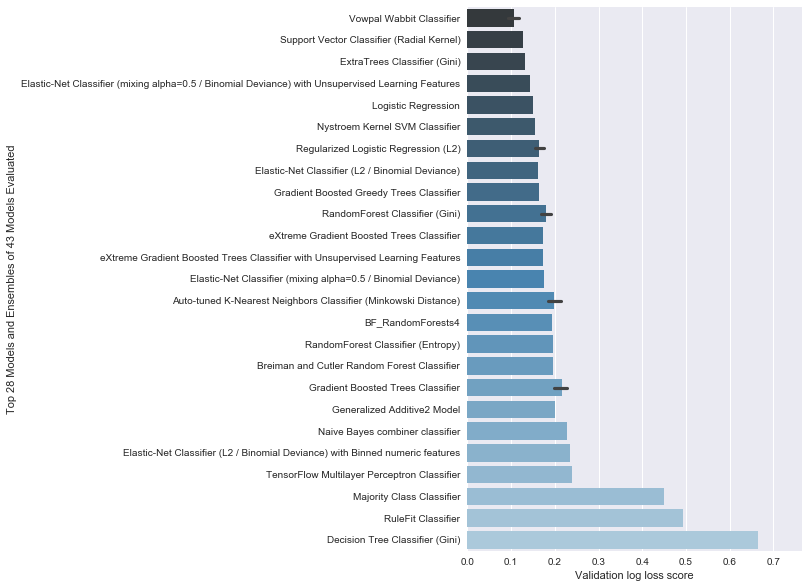

In [13]:
plot_results(custom_cv_df.sort_values(by='val_logloss'))

### At DataRobot, the top models get ran through a final cross-validation and hyperparemeter tuning, and the best ones are combined into ensembles, or blenders.  Note that the RandomForest approximation for BuzzFeed came in 15th on our validation dataset.

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


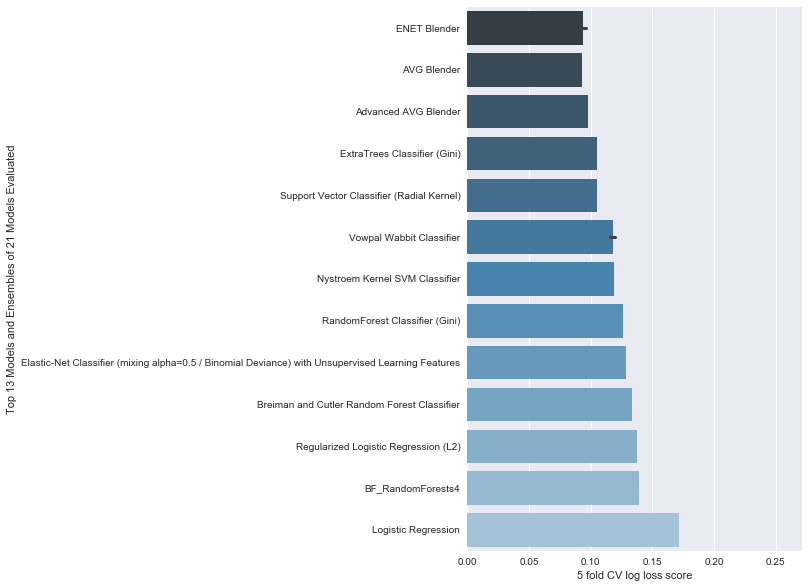

In [14]:
plot_results(custom_cv_df.dropna().sort_values(by='cross_val_logloss'), 'cross_val_logloss')

Our best performing model was an ensemble of our top 3 performing individual models (by CV score): ExtraTrees Classifier (Gini), Vowpal Wabbit Classifier, and a Support Vector Classifier (Radial Kernel), all fed in to an ElasticNet Classifier using (L2/ Binomial Deviance)

All ensembling is natively done in DataRobot, and combines the "best parts" of multiple models to produce more robust predictions.

![Enet](ENET_Blue_Print.png "title")
To take a look at the preprocessing that DataRobot is doing for us for the base models in this ensemble, first we can see **Vowpal Wabbit Classifier:**
![vowpal](vowpal_bp.png)
Next, we can look at the **Support Vector Machine** classifier with Radial Kernel:
![svm](svm_bp.png)
Finally, we can look at our **Extra-Tree's** classifier
![et](extratree_bp.png)

# Accuracy across range of predictions
### Lift charts are a useful way to understand how our model makes predictions along all possible ranges of probabilities.

The Random Forest lift chart is below. Predictions are sorted high to low, and binned in to deciles.  The orange line is the mean actual occurrence of surveillance planes in the validation data, and the blue line is the average predicted probabilities in that decile.  Both of these show well performing models, however you can see with the Random Forest model it under-predicted on some planes in the 4th decile, and then began to slightly overpredict up to the 8th decile.  If we wanted to debug this, we can easily download the data from DataRobot, investigate which features may be driving the errors, and conduct some feature engineering. 

![RandomForest](RF_lift2.png)

The Elastic Net Blender, by comparison, has a much tighter fit to the predicted values and begins to predict the presence of surveillance planes much closer to their actual occurrence in the data set.
![ENET_lift](ENET_Lift2.png)

## Feature Impact

Different machine learning algorithms may find different signals in datasets depending on a number of factors, such as which hyperparemeter tuning was used, the nature of the algorithm (e.g. tree-based vs non-tree based) and gradient-boosting to name a few.  Feature impact is a built-in model evaluation tool that allows you to compare the relative importance of each feature in terms of predictive power across models. Let's
- compare the top features from our best model and the BuzzFeed Random Forest Model

In [31]:
def get_feature_impact(models):
    max_num_features = 5
    for model in models:

        feature_impacts = model.get_feature_impact()
        feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)
        final_names = [(f['featureName'], f['impactNormalized']) for f in feature_impacts[:max_num_features]]
        print(str(model), ':', model.sample_pct)
        print(pd.DataFrame(final_names, columns=['Feature', 'Relative Importance']))
        

In [32]:
get_feature_impact([model, model_100, bf_model])

Model('ENET Blender') : 79.9
     Feature  Relative Importance
0       type             1.000000
1   squawk_1             0.623344
2     steer2             0.260204
3     steer6             0.204206
4  altitude5             0.203783
Model('ENET Blender') : 100.0
    Feature  Relative Importance
0      type             1.000000
1  squawk_1             0.754141
2    steer2             0.516594
3    steer1             0.356682
4    steer5             0.354013
Model('BF_RandomForests4') : 100.0
     Feature  Relative Importance
0     steer2             1.000000
1     steer1             0.668808
2   squawk_1             0.621222
3     steer5             0.332216
4  duration4             0.208446


There are a few interesting things to note here:
- For our best model, we prioritize plane **type**, then **squawk_1**, then the **steer2** feature. 
- Our simulated BuzzFeed Model prioritizes **steer2**, **steer1** and **squawk_1**, which are the same top3 as the BuzzFeed MeanDecrease_Gini importance below
- Right away we see a break in the models, the type of plane will strongly influence predictions in our model, however it is in the bottom of the list for feature importance with Random Forests. 

![BF_Feat](BF_feat_imp.png)
Let's look one level deeper at how the importance of plane type shifts between models

### Looking at Partial Dependence to Identify Differences Between Classifiers

Our ElasticNet ensemble is a combination of predictions from a Vowpal Wabbit Classifier, a Support Vector Machine Classifier (Radial Kernel), and an Extra Trees Classifier (Gini).  Not every model individually picked up plane type as important, but the combination of all three models takes the best from each model. 

Partial dependence looks at the impact of changing individual values for a feature, holding the rest of the model constant, which is a good way to understand how changing your inputs changes predictions, and also to identify new features for feature engineering (Note: not done here to show out of the box performance).

#### Our SVM classifier did not pick up a strong signal with ** plane type **
![svm](x_ray_svm.png)

#### However, our Extra Tree classifier did
![ExtraTrees](x_ray_gini.png)

#### As well as our Vowpal Wabbit classifier, and quite strongly!
![wabbit](x_ray_vowpal.png)

#### However, the BuzzFeed Random Forest Model did not, missing an opportunity.  
![bf](x_ray_bf.png)

It looks like a handful of plane models strongly indicated surveillance in the training data.  This is just one example of the benefit of evaluating multiple models at once, and the ease at which DataRobot allows us to compare and evaluate different models.

Below we see that steer2 and squawk_1 both had a very strong signal, and were picked up strongly with our ENET model as well as BuzzFeed's Random Forest. 

#### Steer 2 Partial Dependence (log scale)- ENET
![ENET_steer](ENET_steer2.png)

#### Squawk Partial Dependence - ENET. We see a large spike at ~4268-4656, which is a common range for Law Enforcement/Military. This range would be a good candidate for a feature if we wanted to do some additional feature engineering
[codes](https://en.wikipedia.org/wiki/Transponder_(aeronautics))
![ENET_steer](ENET_sqwuack.png)

# Make Predictions 

Here we are going to investigate a few questions to compare our results with our ensemble model compared to BuzzFeed's model. 

- Run predictions on our best performing model, the ElasticNet Blender, that has been trained on 100% of the training data, and collect the top 3 reasons each prediction was made
- Compare our best models' predictions to BuzzFeeds original top 100 predictions, which were provided in the file **candidates_annotated.csv** on their github
- Compare our approximated BuzzFeed model (BF_RandomForest4) to their results, to see how well we recreated their results
- Investigate if our best model made the same error of falsely identifying 16 SkyDiving planes, which were discussed in the BuzzFeed Article
- Finally, we will look at our unique predictions, and see what we identified differently

Let's grab the models we want to focus on, and check out what features they think are important before we make predictions

In [30]:
#ENET at 79%
model_id = custom_cv_df.model_id[2]
model = dr.Model.get(project=project.id, model_id=model_id)
print(model_id, ":", model.sample_pct, model.model_type) #79.9

#ENET at 100%
model_100_id=custom_cv_df.model_id[8]
model_100 = dr.Model.get(project=project.id,model_id=model_100_id)
print(model_100_id, ":", model_100.sample_pct, model_100.model_type) #what we'll use for predictions

#buzzfeed model at 100%
bf_model_id= custom_cv_df.model_id[26]
bf_model = dr.Model.get(project=project.id,model_id=bf_model_id)
print(bf_model_id, ":", bf_model.sample_pct, bf_model.model_type)


59b57f308962b210850c1cd1 : 79.9 ENET Blender
59b6f112c8089117b1383188 : 100.0 ENET Blender
59bbff68c8089150da586c39 : 100.0 BF_RandomForests4


## Read in our best models predictions and reason codes and compare with BuzzFeed's actual pics from their article

In [33]:
#In order to return the adshex so we can merge, we needed to download the predictions and reason codes from the GUI
preds = pd.read_csv('DR_Surveillance_Planes_No_Holdout_Strat_ENET_Blender_(85+86+87)_(88)_100_Informative_Features_predict_RC_3_lt_0.573_gt_0.574.csv')

#add in our prediction threshold for surveillance planes. For our cross-validation model,0.4380 maximized the F1-Score.  
preds['spyplane'] = np.where(preds.Prediction >=0.4380, 1,0)

#keep our top 100 pics like buzzfeed did
dr_top_100=preds.sort_values(by='Prediction', ascending=False).head(100)

#Read in buzzfeed's actual predictions they provided on their website and add in their 0.5 prediciton threshold
buzzfeed_pics = pd.read_csv('candidates_annotated.csv')
buzzfeed_pics['BF_spyplane']= np.where(buzzfeed_pics.surveil >=0.5, 1,0)

#clean up erroneous columns from loading
buzzfeed_pics.drop('Unnamed: 7', axis=1, inplace=True)


print("DataRobot Predicted surevillance plane:", preds.spyplane.sum())
print("BuzzFeed Predicted surveillance planes:", len(buzzfeed_pics[buzzfeed_pics.surveil>0.5])) # default 0.5 RF threshold

#are our top 100 planes the same as theirs?
dr_dif_pics = dr_top_100[~dr_top_100.adshex.isin(buzzfeed_pics.adshex)]#in dr_top_100 but excluding buzz_feed_top 100
print("Number of DataRobot top 100 pics that differ from the BuzzFeed top 100:",len(dr_dif_pics))



DataRobot Predicted surevillance plane: 80
BuzzFeed Predicted surveillance planes: 69
Number of DataRobot top 100 pics that differ from the BuzzFeed top 100: 58


### We'll look at our new predictions shortly. First, let's see if our model made similar errors to the ones they call out in their article. 

### Did the DataRobot Ensemble predict skydiving flights highly like Random Forests?  It turns out 16 skydiving company planes made BuzzFeed's top 100 (including 2 for military parachuting), with an average prediction of 0.53.  

In [43]:
#create a dataframe of the planes BuzzFeed predicted as surveillance, but with our reason codes for why we gave them low probability

# 'Surveil" is BuzzFeed's model's probability, and "Prediction' is DataRobot's ENET Blender
both_pics = buzzfeed_pics.merge(preds,how='left', on='adshex' )

skydiving=both_pics[both_pics['notes'].str.contains("Skydiving|skydiving")==True] #buzzfeed notes identifying skydiving planes
print("Total number of skydiving planes in BuzzFeed's top 100:", len(skydiving))
print("Number Skydiving planes BuzzFeed model predicted as surveillance:", len(skydiving[skydiving.surveil >0.5]))
print("Number Skydiving planes DataRobot model predicted as surveillance:", len(skydiving[skydiving.spyplane==1]))
print("BuzzFeed's avg predicted probability for skydiving:", np.round(skydiving.surveil.mean(),3))
print("DataRobot's avg predicted probability for same planes:", np.round(skydiving.Prediction.mean(),3))

skydiving.head(3)

Total number of skydiving planes in BuzzFeed's top 100: 16
Number Skydiving planes BuzzFeed model predicted as surveillance: 10
Number Skydiving planes DataRobot model predicted as surveillance: 1
BuzzFeed's avg predicted probability for skydiving: 0.539
DataRobot's avg predicted probability for same planes: 0.197


,other,surveil,adshex,squawk_1,name,reg,notes,BF_spyplane,row_id,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane
23,0.276,0.724,A5DD36,4444,PARACLETE AVIATION LLC,N477XP,"Skydiving, also military parachute training",1,9127,0.652692,++,steer2,'0.183848157797',++,squawk_1,'4444',++,type,'C208',1
36,0.369,0.631,AB30DD,206,VERTICAL AIR INC,N820AB,Skydiving,1,15836,0.248584,+++,steer2,'0.248351687836',--,duration1,'0.0',++,steer5,'0.0330740348167',0
38,0.373,0.627,A00A41,204,VERTICAL AIR INC,N101UV,Skydiving,1,134,0.229020,+++,steer2,'0.229668377418',++,steer5,'0.0386399526253',--,duration1,'0.0',0


In [50]:
#See what drove our predictions low for these planes by looking at our Reason Codes
def get_stats(group):
    return {'count': group.count(), 'mean': group.mean()}


skydiving.groupby(['Reason 1 Feature', 'Reason 1 Strength'])['Prediction'].apply(get_stats).unstack().sort_values(by='count', ascending=False)#.sort_values(by= 'spyplane', ascending=False))


count      mean
Reason 1 Feature Reason 1 Strength                 
steer2           +++                  4.0  0.203638
boxes3           --                   2.0  0.105832
squawk_1         +++                  2.0  0.205345
                 --                   2.0  0.069676
                 ---                  2.0  0.156787
steer2           ++                   2.0  0.430864
type             ++                   2.0  0.196608

In [51]:
#let's look at the second most important reason
skydiving.groupby(['Reason 2 Feature', 'Reason 2 Strength'])['Prediction'].apply(get_stats).unstack().sort_values(by='count', ascending=False)#.sort_values(by= 'spyplane', ascending=False))


count      mean
Reason 2 Feature Reason 2 Strength                 
steer2           ++                   6.0  0.129311
boxes3           --                   3.0  0.206576
steer5           ++                   2.0  0.196172
duration1        --                   1.0  0.248584
duration5        --                   1.0  0.173624
squawk_1         ++                   1.0  0.652692
                 --                   1.0  0.115324
type             +++                  1.0  0.166613

 Looks like our ensemble model learned to differentiate the skydiving planes that were problematic in the Random Forest model, returning only 1 prediction in our top 100 that was flagged as skydiving by their analysis.  Steer2 came up frequently as the most important reason for us, however our other features balanced it out. Our feature impact showed the Steer2 was ~ 50% as predictive as Type, so even though it was our top reason code, it didn't drive our predictin above our threshold.
 
 For the same 16 planes they identified as skydiving, our model's average predicted probability was 0.197, well below our prediction thershold.

## Next, let's see how well the approximated RandomForest model we built matches their predictions.  

In [44]:
#import buzzfeed reason codes for RandomForest Predictions
BFreasons = pd.read_csv("DR_Surveillance_Planes_No_Holdout_Strat_BF_RandomForests4_(74)_100_Informative_Features_predict_RC_3_lt_0.429_gt_0.433.csv")

#store the top 100 predictions
BF_100 = BFreasons.sort_values(by='Prediction', ascending = False).head(100)

#add in the surveillance prediction at 0.5 threshold
BF_100['BF_spyplane'] = np.where(BF_100.Prediction >=0.5,1,0)

#separate out planes our approximation predicted but weren't in the true BuzzFeed top 100
dif_planes = BF_100[~BF_100.adshex.isin(buzzfeed_pics.adshex)]
print("DataRobot's approximation of the BuzzFeed model included all but ", len(dif_planes), 'of their top 100 pics')

DataRobot's approximation of the BuzzFeed model included all but  6 of their top 100 pics


In [7]:
dif_planes

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,BF_spyplane
8743,8743,A584B4,0.4620,+++,squawk_1,'4405',++,steer1,'0.0649350649351',--,steer6,'0.239332096475',0
12001,12001,A8138E,0.4580,+++,squawk_1,'4543',++,steer2,'0.0866959648422',++,steer1,'0.0455453455853',0
14056,14056,A9BEE8,0.4545,+++,squawk_1,'5101',++,steer1,'0.0819981149859',++,steer2,'0.0721017907634',0
17265,17265,AC783C,0.4520,+++,steer2,'0.149237472767',--,steer8,'0.0800653594771',++,duration4,'0.0379146919431',0
14463,14463,AA1A68,0.4515,+++,steer2,'0.146870729708',--,duration5,'0.0056338028169',++,duration4,'0.121126760563',0
19062,19062,ADFC6E,0.4495,+++,squawk_1,'5613',++,altitude5,'0.948066298343',++,steer1,'0.0729281767956',0


We were able to recreate 94 of their top 100 pics, which is a decent approximation.  Considering we identified the same top features they reported on, we'll assume our reason codes are a fair representation of their model.

## Below we look at the top reasons that drove predictions for our BuzzFeed approximation, and our best model.  The BuzzFeed model focused heavily on steer2, as indicated in their article, however completely ignored the plane type, which our ensemble found a strong signal with.

In [45]:
print("Most Common Primary Reasons for Top 100 Predictions for BuzzFeed, then DataRobot")
for frame in [BF_100, dr_top_100]:
    
    for reason in ["Reason 1 Feature"]:#, "Reason 2 Feature"]:
    #print(frame[(frame['Reason 1 Feature']=='type')].groupby(['Reason 1 Value']).sum())
    
        print(frame.groupby([reason]).sum().sort_values(by= 'Prediction', ascending=False))
BF_100.BF_spyplane.sum()

Most Common Primary Reasons for Top 100 Predictions for BuzzFeed, then DataRobot
                  row_id  Prediction  BF_spyplane
Reason 1 Feature                                 
steer2            780109     51.2975           65
squawk_1          184476      8.2165            9
steer1             13961      1.6750            2
altitude3          17454      0.4835            0
                  row_id  Prediction  spyplane
Reason 1 Feature                              
type              488597   28.919067        36
squawk_1          239872   17.687226        23
steer2            189798   12.749556        17
altitude5          26556    0.921161         1
steer5              7448    0.582261         1
steer3              9811    0.474733         1


76

Below, we look at the plane types that our model identified.  This is likely the result of our ensembled predictions.

In [245]:
print(dr_top_100[(dr_top_100['Reason 1 Feature']=='type')].groupby(['Reason 1 Value']).sum())
#dr_top_100.groupby(['Reason 1 Feature']).sum().sort_values(by= 'spyplane', ascending=False)


                row_id  Prediction  spyplane
Reason 1 Value                              
'C182'          218180   11.547442        13
'C206'           49480    4.264813         7
'C208'           33903    2.139374         3
'T206'          187034   10.967439        13


In [275]:
#the six we got wrong. All below the 0.5 threshold
BF_100[~BF_100.adshex.isin(buzzfeed_pics.adshex)]

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,BF_spyplane
8743,8743,A584B4,0.4620,+++,squawk_1,'4405',++,steer1,'0.0649350649351',--,steer6,'0.239332096475',0
12001,12001,A8138E,0.4580,+++,squawk_1,'4543',++,steer2,'0.0866959648422',++,steer1,'0.0455453455853',0
14056,14056,A9BEE8,0.4545,+++,squawk_1,'5101',++,steer1,'0.0819981149859',++,steer2,'0.0721017907634',0
17265,17265,AC783C,0.4520,+++,steer2,'0.149237472767',--,steer8,'0.0800653594771',++,duration4,'0.0379146919431',0
14463,14463,AA1A68,0.4515,+++,steer2,'0.146870729708',--,duration5,'0.0056338028169',++,duration4,'0.121126760563',0
19062,19062,ADFC6E,0.4495,+++,squawk_1,'5613',++,altitude5,'0.948066298343',++,steer1,'0.0729281767956',0


## Let's examine our new predictions. Out of 100 potential surveillance planes from our two models, we have less than half in common, with the DataRobot model identfying 58 new planes from BuzzFeed's orginal predictions.  Did we find anything interesting?

In [8]:
#read in FAA data for supplementary plane info
faa_reg = pd.read_csv('faa-registration.csv')
faa_reg.rename(columns={'MODE S CODE HEX':'adshex'}, inplace=True)

#create a dataframe of our new pics
dr_new_pics = dr_top_100[dr_top_100.adshex.isin(dr_dif_pics.adshex)]
print(len(dr_new_pics))
dr_new_pics_annotated= dr_new_pics.merge(faa_reg, how='left', on='adshex')


#clean up our columns
cols = ['row_id','adshex', 'Prediction', 'NAME', 'Reason 1 Strength', 'Reason 1 Feature', 'Reason 1 Value', 'Reason 2 Strength',
 'Reason 2 Feature', 'Reason 2 Value', 'Reason 3 Strength', 'Reason 3 Feature', 'Reason 3 Value', 'spyplane', 'N-NUMBER',
 'SERIAL NUMBER',]
dr_new_clean = dr_new_pics_annotated[cols]

#see if repeat companies come up
dr_new_clean.groupby(['NAME']).spyplane.sum().sort_values(ascending=False)[0:10]

58


NAME
CIVIL AIR PATROL                 6
AEROPTIC LLC                     3
DUKE DAVID A                     1
K AND L AVIATION INCORPORATED    1
JET SET AIRCRAFT INC             1
IFL GROUP INC                    1
USDA FOREST SERVICE FEPP         1
FLORIDA HIGHWAY PATROL           1
BILLINGS FLYING SERVICE INC      1
NORTHROP GRUMMAN SYSTEMS CORP    1
Name: spyplane, dtype: int64

In [9]:
dr_new_pics_annotated

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane,N-NUMBER,SERIAL NUMBER,MFR MDL CODE,ENG MFR MDL,YEAR MFR,TYPE REGISTRANT,NAME,STREET,STREET2,CITY,STATE,ZIP CODE,REGION,COUNTY,COUNTRY,LAST ACTION DATE,CERT ISSUE DATE,CERTIFICATION,TYPE AIRCRAFT,TYPE ENGINE,STATUS CODE,MODE S CODE,FRACT OWNER,AIR WORTH DATE,OTHER NAMES(1),OTHER NAMES(2),OTHER NAMES(3),OTHER NAMES(4),OTHER NAMES(5),EXPIRATION DATE,UNIQUE ID,KIT MFR,KIT MODEL,X35
0,2917,A1A859,0.935934,+++,type,'T206',++,steer2,'0.102822518791',++,observations,'65190',1,206AM,T20608436,2073303,41533.0,2003.0,3.0,PACIFIC GAS AND ELECTRIC CO,HAGAR 8A,7843 EARHART RD,OAKLAND,CA,946214529,4,1.0,US,20150406.0,20150406.0,1N,4.0,1.0,V,50324131.0,NaN,20031223.0,NaN,NaN,NaN,NaN,NaN,20180430.0,84609.0,NaN,NaN,NaN
1,18481,AD6E27,0.865010,+++,type,'C182',++,altitude1,'0.00721695985566',++,steer2,'0.06450157871',1,96455,18266726,2072732,17026.0,1978.0,5.0,CITY OF PHOENIX,102 E DEER VALLEY RD,NaN,PHOENIX,AZ,850245104,4,13.0,US,20160218.0,19790222.0,1N,4.0,1.0,V,53267047.0,NaN,19781209.0,POLICE AIR SUPPORT UNIT,NaN,NaN,NaN,NaN,20190731.0,934240.0,NaN,NaN,NaN
2,10146,A69E5F,0.803550,+++,type,'C182',++,steer1,'0.141852874718',++,steer2,'0.0783329148883',1,52534,18262659,2075816,17026.0,1973.0,3.0,PUMA AERIALS LLC,7579 AMARILLO RD,NaN,DUBLIN,CA,945682223,4,1.0,US,20151019.0,20151019.0,1N,4.0,1.0,V,51517137.0,NaN,19731130.0,NaN,NaN,NaN,NaN,NaN,20181031.0,622485.0,NaN,NaN,NaN
3,11605,A7D2DA,0.751176,+++,type,'C206',++,steer2,'0.0725498515062',++,steer1,'0.0555791260076',1,603ET,U20602230,2073353,17040.0,1973.0,3.0,SANBORN MAP CO,1935 JAMBOREE DR,NaN,COLORADO SPRINGS,CO,809205398,S,41.0,US,20160314.0,20130424.0,1N,4.0,1.0,V,51751332.0,NaN,19890824.0,NaN,NaN,NaN,NaN,NaN,20190430.0,771830.0,NaN,NaN,NaN
4,4387,A27FBD,0.724091,+++,squawk_1,'7314',++,altitude2,'0.0316715542522',++,duration1,'0.382978723404',1,260HS,260,7090551,52118.0,1999.0,3.0,BILLINGS FLYING SERVICE INC,6309 JELLISON RD,NaN,BILLINGS,MT,591019306,S,111.0,US,20160509.0,20160509.0,1N,4.0,2.0,V,50477675.0,NaN,19990504.0,NaN,NaN,NaN,NaN,NaN,20190531.0,685662.0,NaN,NaN,NaN
5,12448,A87457,0.723211,+++,type,'C182',++,steer1,'0.0875665215288',++,altitude1,'0.0174165457184',1,644CP,18282247,2072703,41808.0,2010.0,5.0,CIVIL AIR PATROL,105 S HANSELL ST BLDG 714,NaN,MAXWELL AFB,AL,361125937,7,101.0,US,20160616.0,20101116.0,1N,4.0,1.0,V,52072127.0,NaN,20100914.0,NaN,NaN,NaN,NaN,NaN,20191130.0,1051902.0,NaN,NaN,NaN
6,12372,A85F6B,0.700849,+++,type,'C182',++,boxes5,'0.0',++,altitude1,'0.0326663944467',1,639CP,18281534,2072703,41530.0,2005.0,5.0,CIVIL AIR PATROL,105 S HANSELL ST BLDG 714,NaN,MAXWELL AFB,AL,361125937,7,101.0,US,20170317.0,20050509.0,1N,4.0,1.0,V,52057553.0,NaN,20050217.0,NaN,NaN,NaN,NaN,NaN,20200731.0,145759.0,NaN,NaN,NaN
7,5816,A38E76,0.664437,+++,squawk_1,'4707',++,steer5,'0.0463425715584',++,steer1,'0.0590640617901',1,3280X,310L-0130,2074230,17027.0,1967.0,3.0,COASTAL DEFENSE INC,155 ORCHARD HILL LN,NaN,MILL HALL,PA,177518890,1,35.0,US,20170207.0,20100504.0,1N,5.0,1.0,V,50707166.0,NaN,19670330.0,NaN,NaN,NaN,NaN,NaN,20200430.0,192003.0,NaN,NaN,NaN
8,17972,ACF456,0.648036,+++,type,'T206',++,steer1,'0.0818713450292',++,boxes1,'0.481481481481',1,9338Z,U20606404,2073357,17040.0,1981.0,3.0,AEROPTIC LLC,250 CLARK ST,NaN,NORTH ANDOVER,MA,018451018,E,9.0,US,20170501.0,20170501.0,1N,4.0,1.0,V,53172126.0,NaN,19810821.0,NaN,NaN,NaN,NaN,NaN,20200531.0,630421.0,NaN,NaN,NaN
9,18701,ADA41A,0.643630,+++,type,'C208',++,steer2,'0.0983263598326',++,steer5,'0.0453277545328',1,97826,208B1223,2073701,52257.0,2006.0,3.0,U S BANK NA,1310 MADRID ST,NaN,MARSHALL,MN,562584099,C,83.0,US,20141009.0,20120201.0,46,4.0,2.0,V,53322032.0,NaN,20160919.0,U S BANK EQUIPMENT FINANCE DIVISION,NaN,NaN,NaN,NaN,20180228.0,299989.0,NaN,NaN,NaN


## Grouping by our Top Reason for prediction on our new, differnet predictions, we see that they are largley driven by plane type, which was not in BuzzFeed's Random Forest important feature list. Put another way, the new important feature we identified (plane type) by evaluating multiple models was the main driver in our newly identified predictions

In [280]:
dr_new_clean.groupby(['Reason 1 Feature']).sum().sort_values(by= 'spyplane', ascending=False)

,row_id,Prediction,spyplane
Reason 1 Feature,,,
type,408021,21.722752,28
squawk_1,128778,6.715369,9
altitude5,26556,0.921161,1
steer5,7448,0.582261,1


## We here at DataRobot are by no means investigative journalists, but some curious names pop up below in our new predictions.

In [376]:
dr_new_clean.to_csv('New_DataRobot_spyplane_predictions.csv') #export and send to buzzfeed
dr_new_clean

,row_id,adshex,Prediction,NAME,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane,N-NUMBER,SERIAL NUMBER
0,2917,A1A859,0.935934,PACIFIC GAS AND ELECTRIC CO,+++,type,'T206',++,steer2,'0.102822518791',++,observations,'65190',1,206AM,T20608436
1,18481,AD6E27,0.865010,CITY OF PHOENIX,+++,type,'C182',++,altitude1,'0.00721695985566',++,steer2,'0.06450157871',1,96455,18266726
2,10146,A69E5F,0.803550,PUMA AERIALS LLC,+++,type,'C182',++,steer1,'0.141852874718',++,steer2,'0.0783329148883',1,52534,18262659
3,11605,A7D2DA,0.751176,SANBORN MAP CO,+++,type,'C206',++,steer2,'0.0725498515062',++,steer1,'0.0555791260076',1,603ET,U20602230
4,4387,A27FBD,0.724091,BILLINGS FLYING SERVICE INC,+++,squawk_1,'7314',++,altitude2,'0.0316715542522',++,duration1,'0.382978723404',1,260HS,260
5,12448,A87457,0.723211,CIVIL AIR PATROL,+++,type,'C182',++,steer1,'0.0875665215288',++,altitude1,'0.0174165457184',1,644CP,18282247
6,12372,A85F6B,0.700849,CIVIL AIR PATROL,+++,type,'C182',++,boxes5,'0.0',++,altitude1,'0.0326663944467',1,639CP,18281534
7,5816,A38E76,0.664437,COASTAL DEFENSE INC,+++,squawk_1,'4707',++,steer5,'0.0463425715584',++,steer1,'0.0590640617901',1,3280X,310L-0130
8,17972,ACF456,0.648036,AEROPTIC LLC,+++,type,'T206',++,steer1,'0.0818713450292',++,boxes1,'0.481481481481',1,9338Z,U20606404
9,18701,ADA41A,0.643630,U S BANK NA,+++,type,'C208',++,steer2,'0.0983263598326',++,steer5,'0.0453277545328',1,97826,208B1223


# Some interesting observations in DataRobot's new predictions
- 6 planes from the **Civil Air Patrol**, which performs search and rescue missions
- 1 plane from **Chapparal Air Group**, which is a front for the **DEA** as identified in BuzzFeed's article. They missed this one.
- 1 plane from **Coastal Defense Inc**, which is a small government contractor that employees former US Special Forces troops, with the mission " To provide a completely integrated team for public and private agencies to use against threats through assessment, training, technology, and equipment; Coastal Defense Inc. is a Service Disabled Veteran-Owned Small Business (SDVOSB) employing highly trained Special Operations veterans.". They've been awarded a number of aviation specific intelligence contracts
![coastal](coastal.png)
- A number of law enforcement planes, including the **Monterrey Country Sherrif's office, Texas Department of Public Safety, Florida Highway Patrol, California Highway Patrol**, and the **City of Phoenix**
- **Pacific Gas and Electric Co**, which had the highest probability of our new pics (0.936).  Interestingly, they started flying aerial patrols to spot wildfires in 2016 [PG&E Press Release](https://www.pge.com/en/about/newsroom/newsdetails/index.page?title=20170619_pge_begins_daily_aerial_patrols_to_spot_and_speed_wildfire_response)
- A number of mapping companies, including Sanborn Map Co, Aerial Cartographics of America Inc, Aeroptic LLC
- A host of small companies with little info, like Ricepyle LLC, Sierra Foxtrot LTD, Arena2Mare LLC, and others.

These were just from a first pass at the looking at some interesting names for companies, but we would love to hear back from BuzzFeed on any new findings!

# Let's be fair here, did our model miss anything exciting that the BuzzFeed Random Forest picked up? We'll filter out their unique predictions, and see what we can find

In [47]:
bf_dif_pics = buzzfeed_pics[~buzzfeed_pics.adshex.isin(dr_top_100.adshex)] #in buzzfeed but exclusing datarobot pics
len(bf_dif_pics) #obviously same as before

58

In [48]:
#buzzfeed unique pics that were missed in the top 100, but filtered out for obvious non-surveilance flights based on notes
BfNonSurveil = bf_dif_pics[bf_dif_pics['notes'].str.contains("Skydiving|skydiving|University|tours")==True]

#not investigated by BuzzFeed, no notes
NotInvest= sum(bf_dif_pics.notes.isnull())

#percentage
PercNonSurveil = round((len(BfNonSurveil) + NotInvest)/len(bf_dif_pics)*100,2)

print("Out of ", len(bf_dif_pics), "unique predictions,", len(BfNonSurveil), "were related to skydiving, university or helicopter tours. Another",NotInvest,"pics weren't investigated and had no notes, which accounts for", PercNonSurveil,"% of differnet pics and don't appear to be surveillance planes")
print("It looks like we missed a few law enformcement planes, and some interesting contractors. We wonder if our new pics will turn up with something similar")
#show only interesting buzzfeed different planes
bf_dif_pics[(~bf_dif_pics.adshex.isin(BfNonSurveil.adshex))].groupby(['name','notes']).sum().sort_values(by='surveil', ascending=False)



Out of  58 unique predictions, 21 were related to skydiving, university or helicopter tours. Another 16 pics weren't investigated and had no notes, which accounts for 63.79 % of differnet pics and don't appear to be surveillance planes
It looks like we missed a few law enformcement planes, and some interesting contractors. We wonder if our new pics will turn up with something similar


,,other,surveil,squawk_1,BF_spyplane
name,notes,,,,
MIDWEST AERIAL IMAGING,DHS front,1.0855,0.9145,8802,0
TWIN OTTER INTERNATIONAL LTD,Contractor that performs scientific research and also tests equipment manufactured for the military,0.2760,0.7240,5134,1
DYNAMIC AVLEASE INC,"Contractor with large fleet of planes, activities include sterile insect release and scientific research; also operates planes under Saturn Arch and Desert Oll projects, which look for IEDs using ground-penetrating radar and other technologies, but those not in the top 100 matches",0.3065,0.6935,406,1
COMMONWEALTH OF PENNSYLVANIA,State law enforcement,0.3730,0.6270,0,1
DYNAMIC AVLEASE INC,"Contractor with large fleet of planes, activities include sterile insect release and scientific research; also operates planes under Saturn Arch and Desert Owl projects, which look for IEDs using ground-penetrating radar and other technologies, but those not in the top 100 matches",0.3865,0.6135,0,1
645TH AERONAUTICAL ENGINEERING GROUP (AESG),Big Safari,0.3985,0.6015,5366,1
CITY OF ONTARIO,Local law enforcement,0.4060,0.5940,1206,1
WASHINGTON COUNTY,Local law enforcement,0.4245,0.5755,302,1
U S AIR FORCE SPECIAL OPERATIONS COMMAND,US Air Force Special Operations Command,0.4295,0.5705,0,1


# Conclusion

Our original questions were:
* Can we build a more robust model using DataRobot that better predicts surveillance planes?
    * We evaluated 41 models with multiple combinations of preprocessing and feature engineering, tuned hyperparameters using cross validation, evaluated model performance and selected our top performing models in a matter of minutes.
    * Our best ensemble of 3 models had a cross-validation loss of 0.921, compared to our approximation of their RandomForest model's score of .1391, a 34% improvement
* Can we identify new planes that may have been missed? 
    * Yes, we identified 58 different planes, with a few interesting ones that jumped out.  As well, we didn't falsely identify 15 of the 16 skydiving planes their model picked up.
* Can we identify new important features in the model, and do our important features line-up with BuzzFeed's important features?
    * Yes, we found a very strong signal with plane type, in conjunction with squawk_1 and steer_2, which were also in their top features.

**So what is the takeaway?** First, your predictions are always only going to be as good as your training data, and we personally don't know the ins and outs of the 100 planes identified as surveillance beyond what was in the orignal BuzzFeed article.  That said, using only those 597 data points, we were able to identify planes with some very non-standard flight patterns using our model, specifically military training planes (Coastal Defense Inc), Search and Rescue planes (multiple Civil Air Patrol planes), 5 different municipal law enforcement planes, wildfire watch planes (Pacific Gas and Electric), a known DEA front (Chapparal Air),and a number of mapping services (which could be fronts- this came up in BuzzFeed's analysis.  That's pretty solid results out of 20,000 potential candidates.

Secondly, this model's success was largely dependent on BuzzFeed's engineered features (though we would love to test the raw data in DataRobot!).  Data scientists can add break through value when they focus on feature engineering and applying domain knowledge, which is prevented when they spend hours manually evaluating models (which they were not able to.)  DataRobot doesn't automate data science, but it does automate a lot of the manual model building and evaluation that would have taken me literally weeks to do.  For reference, from the time I uploaded data into DataRobot, until I evaluated our final best model of the 41 attempted (including hyperparameter tuning), ** took about 10 minutes, with another 5 to compute predictions.** 

That is the power of automated machine learning.  DataRobot allows data scientists to iterate quickly, focus on feature engineering and model evaluation, and evaluate models from the best open source platforms that they may not be familiar with. 

